In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os

from dotenv import load_dotenv
load_dotenv()

# Variables:
PROJECT_ID=os.getenv('PROJECT_ID')
BUCKET_NAME=os.getenv('BUCKET_NAME')
USER=os.getenv('USER')
LOCATION=os.getenv('LOCATION')
SERVICE_ACCOUNT=os.getenv('SERVICE_ACCOUNT')

## Homework: evaluation

In this homework, we will use the Car price dataset like last week. We'll work with the `MSRP` variable, and we'll transform it to a classification task. 

For the rest of the homework, you'll need to use only these columns:

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`
* `MSRP`

In [ ]:
import pandas as pd

def read_data_gcs(
    data_gcs_uri: str,
):
    df = pd.read_csv(data_gcs_uri)
    
    # Base formatting:
    df.columns = df.columns.str.lower().str.replace(" ", "_")
    categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
    for c in categorical_columns:
        df[c] = df[c].str.lower()
    
    return df

In [ ]:
data_gcs_uri = f"gs://{BUCKET_NAME}/01_linear_regression/data.csv"
df = read_data_gcs(data_gcs_uri)
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1 series m,2011,premium unleaded (required),335.0,6.0,manual,rear wheel drive,2.0,"factory tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1 series,2011,premium unleaded (required),300.0,6.0,manual,rear wheel drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1 series,2011,premium unleaded (required),300.0,6.0,manual,rear wheel drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1 series,2011,premium unleaded (required),230.0,6.0,manual,rear wheel drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1 series,2011,premium unleaded (required),230.0,6.0,manual,rear wheel drive,2.0,luxury,compact,convertible,28,18,3916,34500


In [ ]:
df.dtypes

make                  object
model                 object
year                   int64
engine_fuel_type      object
engine_hp            float64
engine_cylinders     float64
transmission_type     object
driven_wheels         object
number_of_doors      float64
market_category       object
vehicle_size          object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
popularity             int64
msrp                   int64
dtype: object

### Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [ ]:
from sklearn.model_selection import train_test_split

def prepare_split_data(
    df,
    test_size: float = 0.2,
    validation_size: float = 0.2,
    random_state: int = 1,
):
    # Prepare
    df = df.fillna(0)
    # Binary label (we'll handle the rest of the variables later):
    average = df.msrp.mean()
    df['above_average'] = (df.msrp > average).astype(int)
    df = df.rename(columns={"msrp": "price"})

    # Split:
    df_train_full, df_test = train_test_split(
        df, 
        test_size=test_size, 
        random_state=random_state,
    )
    # Obtain validation set from the full train:
    train_size = 1 - test_size
    new_validation_size = validation_size/train_size
    
    df_train, df_val = train_test_split(
        df_train_full, 
        test_size=new_validation_size, 
        random_state=random_state,
    )

    df_train_full = df_train_full.reset_index(drop=True)
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    return df_train_full, df_train, df_val, df_test

In [ ]:
df_train_full, df_train, df_val, df_test = prepare_split_data(df)

In [ ]:
df_train_full.shape, df_train.shape , df_val.shape , df_test.shape

((9531, 17), (7148, 17), (2383, 17), (2383, 17))

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [ ]:
numerical = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
categorical = ['make', 'model', 'year', 'transmission_type', 'vehicle_style']
label = 'above_average'

In [ ]:
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt

def get_auc(
    dataframe,
    label: str,
    feature: str,
    direction: int = 1,
):
    fpr, tpr, _ = roc_curve(dataframe[label], direction * dataframe[feature], pos_label = 1)
    result = auc(fpr, tpr)
    return result, fpr, tpr
    
def plot_roc(
    fpr,
    tpr,
):
    plt.figure(figsize=(5, 5))

    plt.plot(fpr, tpr, label='correlation')
    plt.plot([0, 1], [0, 1], label='45', linestyle='--')
    
    plt.xlabel('label')
    plt.ylabel('feature')
    
    plt.legend()

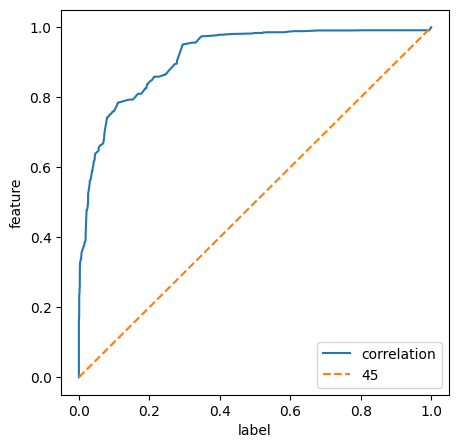

In [ ]:
res, fpr, tpr = get_auc(
    df_train,
    label,
    'engine_hp',
    direction = 1,
)
plot_roc(fpr, tpr)

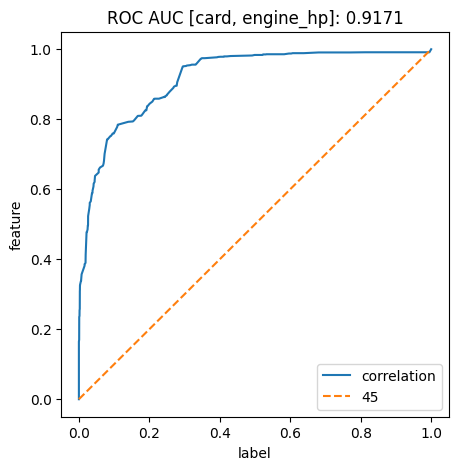

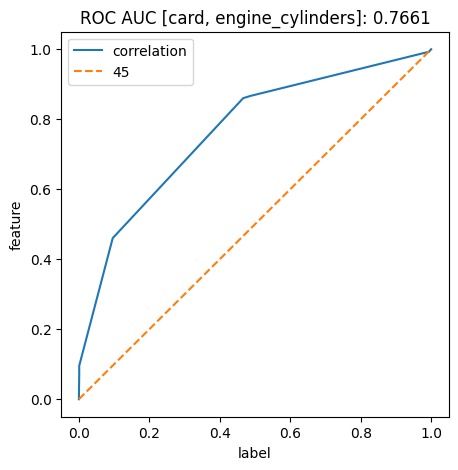

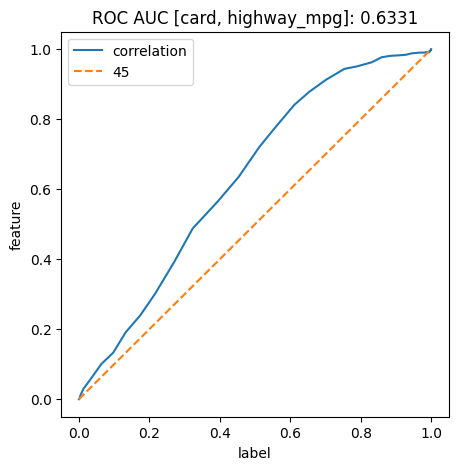

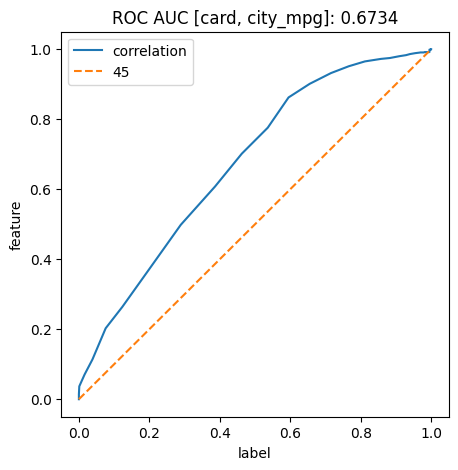

In [ ]:
%matplotlib inline
scores = []

for feature in numerical:
    res, fpr, tpr = get_auc(
    df_train,
    label,
    feature,
    )
    if res < 0.5:
        res, fpr, tpr = get_auc(
            df_train,
            label,
            feature,
            direction = -1,
        )
    plot_roc(fpr, tpr)
    plt.title(f'ROC AUC [{"card"}, {feature}]: %0.4f'%res)
    scores.append(res)

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`✅
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [ ]:
pd.DataFrame(
    {'roc_auc': scores,
     'feature': numerical,
    }).sort_values('roc_auc', ascending = False)

,roc_auc,feature
0,0.917103,engine_hp
1,0.766116,engine_cylinders
3,0.673424,city_mpg
2,0.633059,highway_mpg


### Question 2: Training the model

Apply one-hot-encoding and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

def split_preprocess_train_k_folds(
    df_train,
    df_val,
    train_idx: list,
    val_idx: list,
    label: str,
    cat_features: list,
    num_features: list,
    C=1.0, # Hyperparameters
    solver='liblinear',
    max_iter=1000,
):
    # SPLIT DATASET:
    df_train = df_train.iloc[train_idx].copy()
    df_val = df_val.iloc[val_idx].copy()

    y_train = df_train[label]
    y_val = df_val[label]

    # PREPROCESS:
    ohe = OneHotEncoder(
        sparse=False, # Will return sparse matrix if set True
        handle_unknown='ignore',
    ) 
    mct = make_column_transformer(
        (ohe, cat_features),
        remainder='passthrough',
    )
    X_train = mct.fit_transform(df_train[cat_features + num_features])
    X_val = mct.transform(df_val[cat_features + num_features])

    # TRAIN MODEL:
    model = LogisticRegression(solver = solver, C=C, max_iter=max_iter)
    model.fit(X_train, y_train)

    # PREDICT ON VALIDATION:
    y_pred = model.predict_proba(X_val)[:,1]

    # EVALUATE ON VALIDATION:
    auc = roc_auc_score(y_val, y_pred)

    return auc, model, y_pred, y_val

In [ ]:
auc, model, y_pred, y_val = split_preprocess_train_k_folds(
    df_train = df_train,
    df_val = df_val,
    train_idx = df_train.index,
    val_idx = df_val.index,
    label = label,
    cat_features = categorical,
    num_features = numerical,
)

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979✅

In [ ]:
round(auc,3)

0.983

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48✅
* 0.68
* 0.88

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

In [ ]:
len(precision[:-1]), len(recall[:-1]), len(thresholds)

(1988, 1988, 1988)

Text(0, 0.5, 'rate')

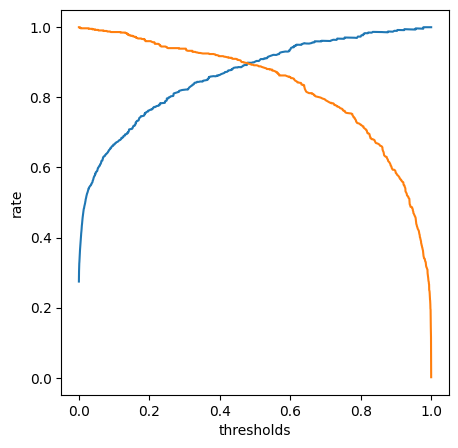

In [ ]:
plt.figure(figsize=(5, 5))

plt.plot(thresholds, precision[:-1], label='precision')
plt.plot(thresholds, recall[:-1], label='recall')

plt.xlabel('thresholds')
plt.ylabel('rate')

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52✅
- 0.72

In [ ]:
eval = pd.DataFrame(
    {'precision': precision[:-1],
     'recall': recall[:-1],
     'thresholds': thresholds,
    })

In [ ]:
eval['f1'] = 2*eval.precision*eval.recall/(eval.precision+eval.recall)

In [ ]:
eval[eval.f1 == eval.f1.max()]

,precision,recall,thresholds,f1
1450,0.92,0.879205,0.548294,0.89914


### Question 5: 5-Fold CV

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

In [ ]:
from tqdm.auto import tqdm
from sklearn.model_selection import KFold
import numpy as np

n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
k_folds_scores = []

for train_idx, val_idx in kfold.split(df_train_full):
        auc, _, _, _ = split_preprocess_train_k_folds(
            df_train_full,
            df_train_full,
            train_idx,
            val_idx,
            label,
            categorical,
            numerical,
        )
        k_folds_scores.append(auc)

How large is standard devidation of the scores across different folds?

- 0.003 ✅
- 0.030
- 0.090
- 0.140

In [ ]:
np.mean(k_folds_scores), np.std(k_folds_scores)

(0.9855340556439373, 0.002209239060976981)

### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10 ✅

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.


In [ ]:
n_splits = 5
for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []
    
    for train_idx, val_idx in kfold.split(df_train_full):
        auc, _, _, _ = split_preprocess_train_k_folds(
            df_train_full,
            df_train_full,
            train_idx,
            val_idx,
            label,
            categorical,
            numerical,
            C, # Hyperparameter
        )
        scores.append(auc)
    
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.940 +- 0.002
C=0.1 0.975 +- 0.003
C=0.5 0.984 +- 0.002
C=10 0.988 +- 0.001
